# Chatbot Mejorado

###Notebook original "ES_Chatbot_bloom_17_12"

In [10]:
# Instalar la biblioteca de Hugging Face y spacy
!pip install transformers spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###0. https://github.com/bigscience-workshop/Megatron-DeepSpeed

Instalamos git, para poder trabajar con el repositorio bigscience-workshop

In [11]:
!git version

git version 2.17.1


In [12]:
!git init

Reinitialized existing Git repository in /content/.git/


In [13]:
!git config –global user.email “smirosarradell@gmail.com”
!git config –global user.name “silmir”

error: key does not contain a section: –global
error: key does not contain a section: –global


In [14]:
!git clone https://github.com/bigscience-workshop/Megatron-DeepSpeed
!cd Megatron-DeepSpeed
!pip install -r requirements.txt

fatal: destination path 'Megatron-DeepSpeed' already exists and is not an empty directory.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [15]:
!git clone https://github.com/NVIDIA/apex
!cd apex
!pip install --global-option="--cpp_ext" --global-option="--cuda_ext" --no-cache -v --disable-pip-version-check .  2>&1 | tee build.log

fatal: destination path 'apex' already exists and is not an empty directory.
Using pip 21.1.3 from /usr/local/lib/python3.8/dist-packages/pip (python 3.8)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>

In [16]:
!git clone https://github.com/microsoft/deepspeed
!cd deepspeed
!rm -rf build
!TORCH_CUDA_ARCH_LIST="7.0" DS_BUILD_CPU_ADAM=1 DS_BUILD_AIO=1 DS_BUILD_UTILS=1 pip install -e . --global-option="build_ext" --global-option="-j8" --no-cache -v --disable-pip-version-check

fatal: destination path 'deepspeed' already exists and is not an empty directory.
/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Using pip 21.1.3 from /usr/local/lib/python3.8/dist-packages/pip (python 3.8)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8/UNKNOWN
Value fo

### 1.Inclusión-Tratamiento de datos para FineTuning modelo

####Inclusión de datos

Transformamos datos originales (BOE) para ser tratados en modelo de Question-Answering, a modelo de generación de texto. Según especificado en repositorio github https://github.com/bigscience-workshop/Megatron-DeepSpeed:

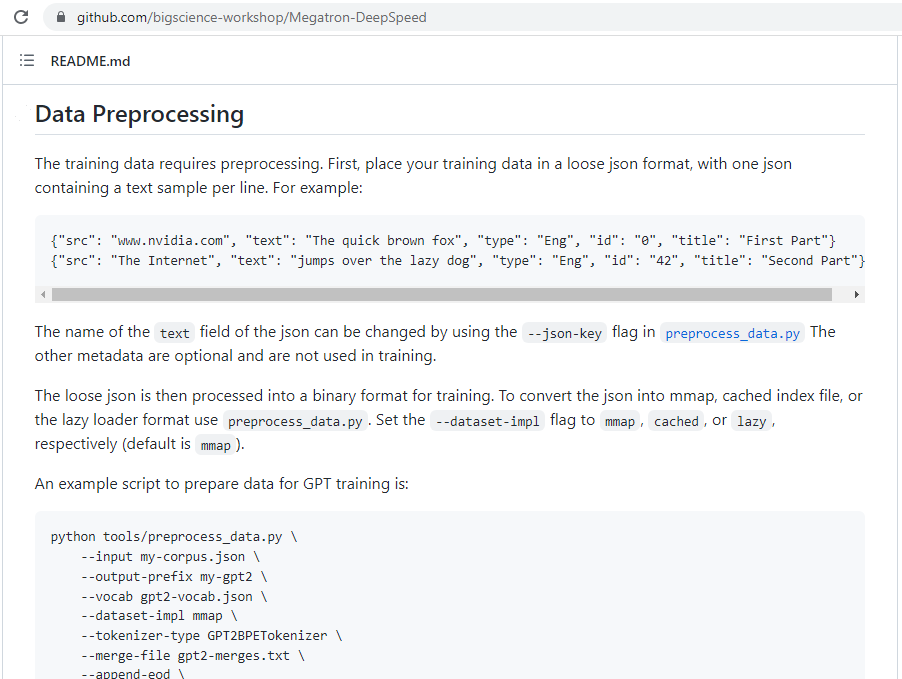

In [17]:
# Revisar documento tratamiento json y bdd original, para adaptar nombre del campo según la imagen anterior

In [18]:
import json
import requests
import random
import string

Leemos el fichero json del repositorio

In [19]:
url = "https://raw.githubusercontent.com/josuemzx/Chatbot-para-refugiados/main/data/Dataset%20propio/data.json"
data = json.loads(requests.get(url).text)

In [20]:
data

{'data': [{'paragraphs': [{'qas': [{'question': '¿Cunato tiempo dura la estancia?',
       'id': 583286,
       'answers': [{'answer_id': 642378,
         'document_id': 1173232,
         'question_id': 583286,
         'text': 'seis meses',
         'answer_start': 50,
         'answer_end': 60,
         'answer_category': None}],
       'is_impossible': False},
      {'question': '¿Cunato tiempo puedo estar en el centro?',
       'id': 583287,
       'answers': [{'answer_id': 642379,
         'document_id': 1173232,
         'question_id': 583287,
         'text': 'seis meses',
         'answer_start': 50,
         'answer_end': 60,
         'answer_category': None}],
       'is_impossible': False},
      {'question': '¿Cuantos dias tiene cuando esta denegada?',
       'id': 583288,
       'answers': [{'answer_id': 642380,
         'document_id': 1173232,
         'question_id': 583288,
         'text': 'quince días',
         'answer_start': 226,
         'answer_end': 237,
        

Buscamos que los datos queden en el formato especificado en la captura de pantalla de arriba: filtramos y cambiamos nombre de etiqueta de diccionario

In [21]:
#A continuación, filtramos un contexto (ejemplo)
data_context_0=data["data"][0]["paragraphs"][0]["context"]
data_context_0

'La estancia en los centros tendrá una duración de seis meses, salvo que con anterioridad al transcurso de este período sea resuelto el expediente administrativo. En caso de resolución denegatoria, el beneficiario dispondrá de quince días para abandonar el centro.\n\nExcepcionalmente, y por razones de necesidad, previo informe del equipo técnico la Dirección del centro podrá proponer a la Dirección General de Inclusión y Atención Humanitaria la autorización, por una sola vez, de una prórroga de estancia hasta la notificación de la resolución del expediente de asilo. Su duración dependerá de las características individuales de cada caso, tras la propuesta de la dirección del centro de forma motivada.'

In [22]:
#Generamos nuevo diccionario con el formato especificado, aplicando el filtro del paso anterior

In [23]:
index1=int(0)+2
type(index1)
test=data["data"][index1]["paragraphs"][0]["context"]
test

'El Alto Comisionado de las Naciones Unidas para los Refugiados (ACNUR), organismo de las Naciones Unidas encargado de proteger a los refugiados y desplazados por persecuciones o conflictos, debe intervenir, de acuerdo con la legislación en vigor, en el procedimiento de concesión del derecho de asilo. En base a esta colaboración, el ACNUR recibe una subvención de la Dirección General de Migraciones.'

Con el siguiente código, los datos quedarían en el formato {"text": datos}\n. No obstante, para el tokenizador se usa el código lista y por ello mantenemos activa la siguiente celda de código.

In [24]:
# data_contexts=""
# index1=int(0)

# for i in data["data"]:
#   data_contexts=data_contexts+'{"text": '+ data["data"][index1]["paragraphs"][0]["context"]+'}\n'
#   index1=index1+1

# print(data_contexts)

In [25]:
data_contexts=[]
index1=int(0)

for i in data["data"]:
  data_contexts.append(data["data"][index1]["paragraphs"][0]["context"])
  index1=index1+1

print(data_contexts)

['La estancia en los centros tendrá una duración de seis meses, salvo que con anterioridad al transcurso de este período sea resuelto el expediente administrativo. En caso de resolución denegatoria, el beneficiario dispondrá de quince días para abandonar el centro.\n\nExcepcionalmente, y por razones de necesidad, previo informe del equipo técnico la Dirección del centro podrá proponer a la Dirección General de Inclusión y Atención Humanitaria la autorización, por una sola vez, de una prórroga de estancia hasta la notificación de la resolución del expediente de asilo. Su duración dependerá de las características individuales de cada caso, tras la propuesta de la dirección del centro de forma motivada.', 'Centro de Acogida a Refugiados (C.A.R.). Son establecimientos públicos destinados a prestar alojamiento, manutención y asistencia psicosocial urgente y primaria, así como otros servicios sociales encaminados a facilitar la convivencia e integrar en la comunidad a las personas que solici

In [26]:
data=data_contexts
data

['La estancia en los centros tendrá una duración de seis meses, salvo que con anterioridad al transcurso de este período sea resuelto el expediente administrativo. En caso de resolución denegatoria, el beneficiario dispondrá de quince días para abandonar el centro.\n\nExcepcionalmente, y por razones de necesidad, previo informe del equipo técnico la Dirección del centro podrá proponer a la Dirección General de Inclusión y Atención Humanitaria la autorización, por una sola vez, de una prórroga de estancia hasta la notificación de la resolución del expediente de asilo. Su duración dependerá de las características individuales de cada caso, tras la propuesta de la dirección del centro de forma motivada.',
 'Centro de Acogida a Refugiados (C.A.R.). Son establecimientos públicos destinados a prestar alojamiento, manutención y asistencia psicosocial urgente y primaria, así como otros servicios sociales encaminados a facilitar la convivencia e integrar en la comunidad a las personas que solic

A partir de aquí la variable `data` tiene el mismo formato que el de github.

####Preparamos ahora los datos para pasarlos al modelo preentrenado (https://huggingface.co/docs/transformers/notebooks)

In [27]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloomz-1b1")

Then pass your text to the tokenizer:

In [29]:
# encoded_input = tokenizer(data)
# print(encoded_input)

The tokenizer returns a dictionary with three important items:

* [input_ids](https://huggingface.co/docs/transformers/main/en/glossary#input-ids) are the indices corresponding to each token in the sentence.
* [attention_mask](https://huggingface.co/docs/transformers/main/en/glossary#attention-mask) indicates whether a token should be attended to or not.
* [token_type_ids](https://huggingface.co/docs/transformers/main/en/glossary#token-type-ids) identifies which sequence a token belongs to when there is more than one sequence.

Return your input by decoding the `input_ids`:

In [30]:
# tokenizer.decode(encoded_input["input_ids"])

As you can see, the tokenizer added two special tokens - `CLS` and `SEP` (classifier and separator) - to the sentence. Not all models need
special tokens, but if they do, the tokenizer automatically adds them for you.

If there are several sentences you want to preprocess, pass them as a list to the tokenizer:

In [31]:
batch_sentences = data
encoded_inputs = tokenizer(batch_sentences)
print(encoded_inputs)

{'input_ids': [[1980, 165182, 413, 874, 28869, 30015, 1035, 92038, 283, 16110, 10252, 15, 65702, 408, 432, 12013, 1077, 521, 206867, 283, 2745, 21243, 11432, 208238, 466, 108128, 106859, 17, 2221, 7094, 283, 43959, 168749, 27591, 15, 466, 13132, 34506, 226871, 12115, 283, 126655, 10123, 852, 57329, 466, 13740, 6149, 3261, 244221, 2817, 15, 393, 841, 53955, 283, 31231, 15, 93342, 18820, 627, 13620, 33768, 366, 67143, 627, 13740, 38962, 184888, 267, 366, 67143, 5251, 283, 1004, 7422, 759, 393, 157290, 22256, 36046, 366, 96201, 15, 841, 1035, 41091, 4603, 15, 283, 1035, 135926, 283, 165182, 6337, 366, 222535, 283, 366, 43959, 627, 108128, 283, 86309, 17, 8816, 92038, 168745, 283, 1066, 37497, 127938, 283, 5213, 7094, 15, 6027, 366, 30549, 283, 366, 41134, 627, 13740, 283, 4204, 218905, 17], [160725, 283, 7775, 744, 1619, 267, 242634, 1347, 375, 38, 17, 36, 17, 53, 34283, 19349, 90241, 27272, 90584, 267, 63998, 205733, 15, 1517, 363, 10062, 393, 53208, 10391, 4812, 33658, 71470, 393, 12563

##### Pad

Sentences aren't always the same length which can be an issue because tensors, the model inputs, need to have a uniform shape. Padding is a strategy for ensuring tensors are rectangular by adding a special *padding token* to shorter sentences.

Set the `padding` parameter to `True` to pad the shorter sequences in the batch to match the longest sequence:

In [32]:
batch_sentences = data
encoded_input = tokenizer(batch_sentences, padding=True)
print(encoded_input)

{'input_ids': [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

The first and third sentences are now padded with `0`'s because they are shorter.

##### Truncation

On the other end of the spectrum, sometimes a sequence may be too long for a model to handle. In this case, you'll need to truncate the sequence to a shorter length.

Set the `truncation` parameter to `True` to truncate a sequence to the maximum length accepted by the model:

In [33]:
batch_sentences = data
encoded_input = tokenizer(batch_sentences, padding=True, truncation=True)
print(encoded_input)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

<Tip>

Check out the [Padding and truncation](https://huggingface.co/docs/transformers/main/en/./pad_truncation) concept guide to learn more different padding and truncation arguments.

</Tip>

##### Build tensors

Finally, you want the tokenizer to return the actual tensors that get fed to the model.

Set the `return_tensors` parameter to either `pt` for PyTorch, or `tf` for TensorFlow:

In [34]:
batch_sentences = data
encoded_input = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt")
print(encoded_input)

{'input_ids': tensor([[     3,      3,      3,  ...,   4204, 218905,     17],
        [     3,      3,      3,  ...,    813,  14340,     17],
        [     3,      3,      3,  ..., 121157,   3280,     17],
        ...,
        [     3,      3,      3,  ...,    366, 107704,     17],
        [     3,      3,      3,  ...,  32863,  10381,     17],
        [     3,      3,      3,  ...,  28738,   1575,     17]]), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])}


In [38]:
# Revisamos tamaño datos de entrenamiento para hacer partición train-test
len(encoded_input['input_ids'])

30

In [ ]:
# batch_sentences = data
# encoded_input = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="tf")
# print(encoded_input)

In [40]:
# Pendiente aplicar train-test split***
train_data=encoded_input['input_ids'][0:20]
len(train_data)

20

In [43]:
eval_data=encoded_input['input_ids'][20:30]
len(eval_data)

10

###Entrenamiento

In [ ]:
from transformers import AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("bigscience/bloomz-1b1")
model = AutoModelForCausalLM.from_pretrained("bigscience/bloomz-1b1")


<Tip>

You will see a warning about some of the pretrained weights not being used and some weights being randomly
initialized. Don't worry, this is completely normal! The pretrained head of the BERT model is discarded, and replaced with a randomly initialized classification head. You will fine-tune this new model head on your sequence classification task, transferring the knowledge of the pretrained model to it.

</Tip>

#### Training hyperparameters

Next, create a [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) class which contains all the hyperparameters you can tune as well as flags for activating different training options. For this tutorial you can start with the default training [hyperparameters](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments), but feel free to experiment with these to find your optimal settings.

Specify where to save the checkpoints from your training:

In [ ]:
# Revisar modelo. ¿Se están considerando los pesos del entrenamiento?***
# ?model

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

#### Evaluate

[Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) does not automatically evaluate model performance during training. You'll need to pass [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) a function to compute and report metrics. The [🤗 Evaluate](https://huggingface.co/docs/evaluate/index) library provides a simple [`accuracy`](https://huggingface.co/spaces/evaluate-metric/accuracy) function you can load with the [evaluate.load](https://huggingface.co/docs/evaluate/main/en/package_reference/loading_methods#evaluate.load) (see this [quicktour](https://huggingface.co/docs/evaluate/a_quick_tour) for more information) function:

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

Call `compute` on `metric` to calculate the accuracy of your predictions. Before passing your predictions to `compute`, you need to convert the predictions to logits (remember all 🤗 Transformers models return logits):

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

If you'd like to monitor your evaluation metrics during fine-tuning, specify the `evaluation_strategy` parameter in your training arguments to report the evaluation metric at the end of each epoch:

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

#### Trainer

Create a [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) object with your model, training arguments, training and test datasets, and evaluation function:

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=eval_data,
    compute_metrics=compute_metrics,
)

Then fine-tune your model by calling [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [ ]:
trainer.train()

###Vuelta al notebook original "ES_Chatbot_bloom_17_12"

In [ ]:
# from transformers import AutoModelForCausalLM, AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("bigscience/bloomz-1b1")
# model = AutoModelForCausalLM.from_pretrained("bigscience/bloomz-1b1")

In [ ]:
!python -m spacy download es_core_news_sm
import es_core_news_sm
nlp = es_core_news_sm.load()

In [ ]:
# Definimos una función que procesa la respuesta del modelo y reemplaza las entidades nombradas por su descripción más detallada
def procesar_respuesta(respuesta):
  # Primero, procesamos la respuesta con spacy para detectar entidades nombradas
  doc = nlp(respuesta)

  # Luego, reemplazamos cada entidad nombrada por su descripción más detallada
  for ent in doc.ents:
    respuesta = respuesta.replace(ent.text, ent.description)

  # Finalmente, devolvemos la respuesta procesada
  return respuesta


In [ ]:
# Obtener la respuesta del modelo a la pregunta "¿...?"
input_text = "¿Por que el cielo es azul?"
input_ids = tokenizer.encode(input_text, return_tensors='pt')
outputs = model.generate(input_ids)


In [ ]:
# Decodificar la respuesta del modelo y procesarla con la función procesar_respuesta
respuesta = tokenizer.decode(outputs[0])
respuesta_procesada = procesar_respuesta(respuesta)

# Mostrar la respuesta procesada en pantalla
print(respuesta_procesada)

###2.Guardar modelo entrenado en fichero

###Vuelta al notebook original "ES_Chatbot_bloom_17_12"

# Resultado:
Con el recurso disponible es es el mejor resultado que me dio.

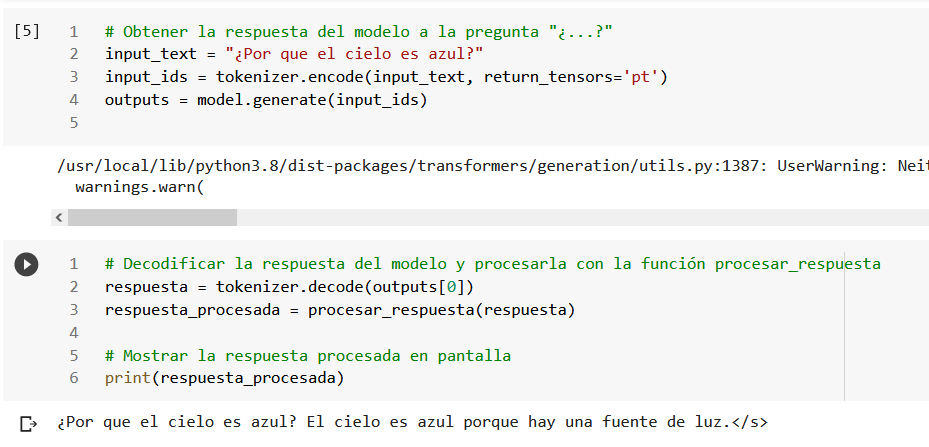

In [ ]:
# ***SM: Falta:
# 1.adaptar e incluir bdd, a considerar para el entrenamiento; y
# 2.añadir código para guardar el nuevo modelo